## Minimising the Action of a Discrete Path via Gradient Descent

In [15]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import action_functions as funcs

In [22]:
t_a, t_b = [0, 10]
N = 50 # number of time steps
t_array = jnp.linspace(t_a, t_b, N)

key = random.PRNGKey(2)

# generate a random initial state
#x_array = jnp.array([jnp.sin(jnp.pi * t / (N-1)) for t in range(N)])
x_array = random.normal(key, shape=(N,))

# boundary conditions
x_array = x_array.at[0].set(0.0)
x_array = x_array.at[-1].set(0.0)

potential = funcs.harmonic_potential
action_fn = lambda x: funcs.action(x, t_a, t_b, N=N, potential=potential)

In [23]:
x, action_array, grad_array = funcs.gradient_descent(action_fn, x_array, learning_rate=0.01, steps=5000)

Step 0, action: 219.04771423339844
Step 100, action: 0.7223392724990845
Step 200, action: 0.29747891426086426
Step 300, action: 0.13999369740486145
Step 400, action: 0.07106801122426987
Step 500, action: 0.03808356449007988
Step 600, action: 0.021258804947137833
Step 700, action: 0.012252604588866234
Step 800, action: 0.007243364583700895
Step 900, action: 0.004368898458778858
Step 1000, action: 0.0026768390089273453
Step 1100, action: 0.0016600870294496417
Step 1200, action: 0.001039060764014721
Step 1300, action: 0.0006548814126290381
Step 1400, action: 0.00041488875285722315
Step 1500, action: 0.00026385608362033963
Step 1600, action: 0.00016828028310555965
Step 1700, action: 0.0001075489490176551
Step 1800, action: 6.884091271786019e-05
Step 1900, action: 4.411420741234906e-05
Step 2000, action: 2.8292608476476744e-05
Step 2100, action: 1.815664472815115e-05
Step 2200, action: 1.1657282811938785e-05
Step 2300, action: 7.486991762561956e-06
Step 2400, action: 4.809818165085744e-06
S

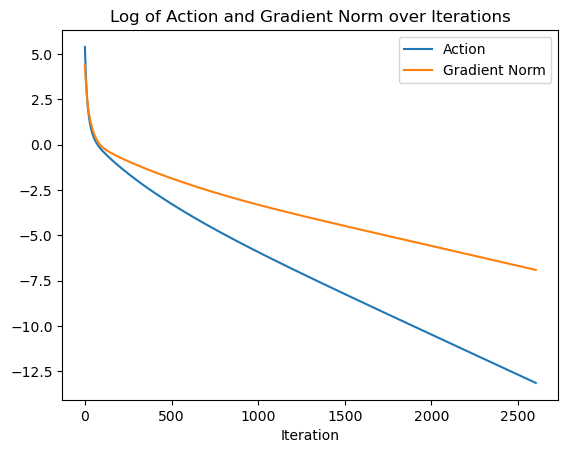

In [24]:
iter_array = jnp.arange(len(action_array))

plt.plot(iter_array, jnp.log(action_array), label='Action')
plt.plot(iter_array, jnp.log(grad_array), label='Gradient Norm')
plt.title('Log of Action and Gradient Norm over Iterations')
plt.xlabel('Iteration')
plt.legend(loc='best')
plt.show()

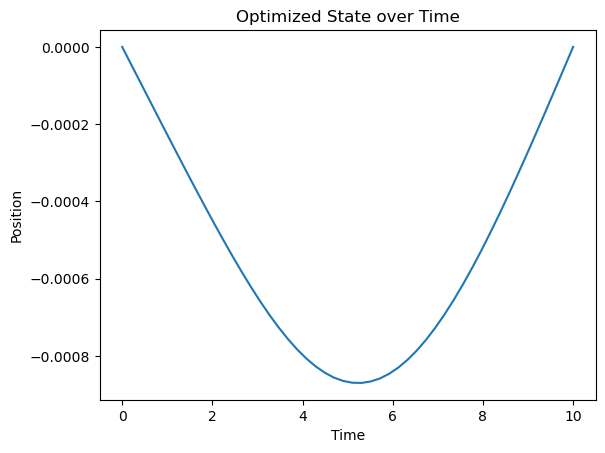

In [26]:
plt.plot(t_array, x, label='Optimized State')
plt.title('Optimized State over Time')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()